# Navigation

---

## 1. Introduction

In this notebook, we solve a prebuilt Banana environment from the [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) engine using the Deep Q-Network algorithm, including enhancements such as Double DQN and Dueling DQN.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import *

## 2. Description of the environment and example run

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

---

### 2.1. Exploring the environment

We explore the environment in the code below

In [2]:
##########################
#### THE ENVIRONMENT #####
##########################

# Initialize the environment
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

# Unity environment agents are represented by brains. In this environment we only have one brain, the agent that picks up
# banans and which we'll train
print('Number of agents in the environment:', len(env.brain_names))
brain_name = env.brain_names[0]
brain = env.brains[brain_name]



##########################
#### THE STATE SPACE #####
##########################

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
print('Total dimensions in state:', len(state))
print('States look like:', state)



######################
## THE ACTION SPACE ##
######################

print('Number of actions:', brain.vector_action_space_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents in the environment: 1
Total dimensions in state: 37
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
Number of actions: 4


### 2.2. Example run

Let's see how a random agent would perform

In [3]:
# Reset the environment, assign the initial state and initialize the score
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0                                          

# Play the environment
while True:
    
    # Select an action at random and send it to the environment
    action = np.random.randint(brain.vector_action_space_size)        
    env_info = env.step(action)[brain_name]        
    
    # Collect the next state and the reward
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    score += reward
    
    # Move onto the next state and exit if it's terminal
    done = env_info.local_done[0]                  
    state = next_state                             
    if done: break
    
print("Final score: {}".format(score))
env.close()

Final score: 0.0


## 3. Training an agent (restart the kernel before running)

Initialize the agent and the environment:

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
from collections import deque
import torch

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset environment and assign initial state
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

# Start an agent
agent = Agent(state_size = len(state), 
              action_size = brain.vector_action_space_size, 
              seed = 0)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Main algorithm

In [2]:
def dqn(n_episodes=2000, 
        max_t=1000, 
        eps_start=1.0, 
        eps_end=0.01, 
        eps_decay=0.995):
    
    ''' Train a Deep Q-Network to solve the environment '''
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    # For each one of the training episodes
    for i_episode in range(1, n_episodes+1):
        
        # Restart the environment and the score
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # Play the episode
        t, done = (0, False)
        while t<max_t and not done:
            t+=1
            
            # Have the agent pick an epsilon-greedy action wrt its current policy
            action = agent.act(state, eps)
            
            # Take the action and store environment output
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]    
            done = env_info.local_done[0]  
            
            # Update agent's knowledge
            agent.step(state, action, reward, next_state, done)
            
            # Set new state as current and update the agent's score
            score += reward   
            state = next_state
            
        # When the episode is done, save scores into our lists, and decrease the epsilon for the next episode
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        # When the agent is trained, we save the weights of the Q-network and exit the routine
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores


Execution of the algorihtm

In [3]:
scores = dqn()

Episode 100	Average Score: 1.40
Episode 200	Average Score: 4.94
Episode 300	Average Score: 7.00
Episode 400	Average Score: 9.81
Episode 500	Average Score: 11.38
Episode 600	Average Score: 11.34
Episode 700	Average Score: 11.76
Episode 800	Average Score: 11.62
Episode 900	Average Score: 12.65
Episode 1000	Average Score: 12.70
Episode 1017	Average Score: 13.03
Environment solved in 917 episodes!	Average Score: 13.03


NameError: name 'plt' is not defined

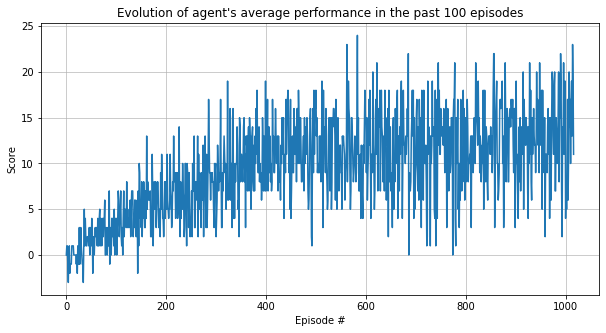

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Evolution of agent's average performance in the past 100 episodes")
plt.grid(alpha=0.8)
plt.show()

## 4. Our agent in action! (restart the kernel before running)

We leverage the network weights learned in section 3 to create an intelligent agent, and watch it interact with its environment.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import *
from collections import deque
import torch

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment, assign the initial state and initialize the score
for i in range(5): env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0       

# Start an agent and assigned it the trained network
agent = Agent(state_size = len(state), 
              action_size = brain.vector_action_space_size, 
              seed = 0)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

                 
# Play the environment
while True:
    
    # Have the agent pick a greedy action wrt its current policy
    action = agent.act(state, 0)

    # Take the action and store environment output
    env_info = env.step(action.astype(int))[brain_name]
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]  
    score += reward

    # Move onto the next state and exit if it's terminal
    done = env_info.local_done[0]                  
    state = next_state                             
    if done: break
    
print("Final score: {}".format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Final score: 20.0
